<a href="https://colab.research.google.com/github/LucaLehigh/Lab-CSE337/blob/main/lab10_half_cheetah_dynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [95]:
import os, math, random, time
from dataclasses import dataclass
from typing import Tuple
import numpy as np
import torch as th
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import gymnasium as gym

def to_t(x):
    return th.as_tensor(x, dtype=th.float32)

def fanin_init(m):
    if isinstance(m, nn.Linear):
        bound = 1.0 / math.sqrt(m.weight.size(1))
        nn.init.uniform_(m.weight, -bound, +bound)
        nn.init.zeros_(m.bias)

class RunningNormalizer:
    """Feature-wise running mean/std (Welford)."""
    def __init__(self, dim, eps=1e-8):
        self.dim = dim
        self.count = 0
        self.mean = np.zeros(dim, dtype=np.float64)
        self.M2   = np.zeros(dim, dtype=np.float64)
        self.eps  = eps

    def update(self, x: np.ndarray):
        x = np.asarray(x)
        if x.ndim == 1: x = x[None, :]
        for v in x:
            self.count += 1
            d = v - self.mean
            self.mean += d / self.count
            d2 = v - self.mean
            self.M2 += d * d2

    @property
    def var(self):
        if self.count < 2: return np.ones(self.dim, dtype=np.float64)
        return self.M2 / (self.count - 1 + 1e-12)

    @property
    def std(self):
        return np.sqrt(self.var + self.eps)

    def normalize(self, x): return (x - self.mean) / self.std
    def denormalize(self, x): return x * self.std + self.mean

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); th.manual_seed(seed)

In [96]:
set_seed(42)
env = gym.make("HalfCheetah-v4")
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
act_low = env.action_space.low
act_high = env.action_space.high

# Find start index of qvel inside obs = [qpos[1:], qvel[:]]
nq = env.unwrapped.model.nq
qvel_start = int(nq - 1)
print("obs_dim:", obs_dim, "act_dim:", act_dim, "qvel_start:", qvel_start)

obs_dim: 17 act_dim: 6 qvel_start: 8


In [97]:
# Create the class and create a class object
class Replay:
    def __init__(self, obs_dim, act_dim, capacity=300000):
        self.obs = np.zeros((capacity, obs_dim), dtype=np.float32)
        self.act = np.zeros((capacity, act_dim), dtype=np.float32)
        self.nxt = np.zeros((capacity, obs_dim), dtype=np.float32)
        self.rew = np.zeros((capacity, 1), dtype=np.float32)
        self.term = np.zeros((capacity, 1), dtype=np.float32)
        self.ptr = 0; self.size = 0; self.cap = capacity

    def add(self, s, a, r, sp, term):
        self.obs[self.ptr] = s
        self.act[self.ptr] = a
        self.nxt[self.ptr] = sp
        self.rew[self.ptr] = r
        self.term[self.ptr] = term
        self.ptr = (self.ptr + 1) % self.cap
        self.size = min(self.size + 1, self.cap)

    def sample(self, batch):
        idx = np.random.randint(0, self.size, size=batch)
        s = self.obs[idx]
        a = self.act[idx]
        sp = self.nxt[idx]
        r = self.rew[idx]
        term = self.term[idx]
        return s, a, r, sp, term

replay = Replay(obs_dim, act_dim)

In [98]:
def collect_random(env, replay, steps=100000, seed=42):
    set_seed(seed)
    obs, _ = env.reset(seed=seed)
    for t in range(steps):
        act = env.action_space.sample()
        nxt, rew, term, trunc, _ = env.step(act)
        done = term or trunc
        replay.add(obs, act, rew, nxt, done)
        obs = nxt if not done else env.reset()[0]
    print(f"Collected {replay.size} samples")


In [99]:
obs_norm = RunningNormalizer(obs_dim)
inp_norm = RunningNormalizer(obs_dim + act_dim)
targ_norm = RunningNormalizer(obs_dim)

# write the function to update the normalizers from the data collected in the buffer
def update_normalizers_from_buffer(replay):
    for i in range(replay.size):
        s = replay.obs[i]
        a = replay.act[i]
        sp = replay.nxt[i]
        ds = sp - s
        obs_norm.update(s)
        inp_norm.update(np.concatenate([s, a]))
        targ_norm.update(ds)

# Call collect_random to populate the replay buffer (i don't understand I added this with gemini help used to run fine now doesn't without this)
collect_random(env, replay)

update_normalizers_from_buffer(replay)
print("Normalizers ready.")

Collected 100000 samples
Normalizers ready.


In [100]:
class DetMLP(nn.Module):
    """Predicts Δstate deterministically."""
    def __init__(self, in_dim, out_dim, width=200, depth=3):
        super().__init__()
        layers = []
        last = in_dim
        for _ in range(depth):
            layers += [nn.Linear(last, width), nn.ReLU()]
            last = width
        layers += [nn.Linear(last, out_dim)]
        self.net = nn.Sequential(*layers)
        self.apply(fanin_init)

    def forward(self, x):
        return self.net(x)

in_dim = obs_dim + act_dim
out_dim = obs_dim
model = DetMLP(in_dim, out_dim, width=200, depth=3)
opt = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ExponentialLR(opt, gamma=0.8)

In [101]:
def train_model(model, replay, epochs=30, batch_size=256):
    losses = []
    model.train()

    for epoch in range(epochs):
        # Sample a random batch
        s, a, _, sp, _ = replay.sample(batch_size)
        ds = sp - s

        # Normalize input [s,a] and target Δs
        x = np.concatenate([s, a], axis=-1)
        x_n = inp_norm.normalize(x)
        y_n = targ_norm.normalize(ds)

        # Convert to tensors
        x_t = to_t(x_n)
        y_t = to_t(y_n)

        # Forward, loss, backward
        pred = model(x_t)
        loss = ((pred - y_t) ** 2).mean()

        opt.zero_grad()
        loss.backward()
        opt.step()

        # Scheduler decay
        scheduler.step()

        losses.append(loss.item())

        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:02d}/{epochs} | Loss: {loss.item():.6f} | LR: {opt.param_groups[0]['lr']:.2e}")

    return losses

Epoch 01/30 | Loss: 1.004647 | LR: 8.00e-04
Epoch 05/30 | Loss: 0.965591 | LR: 3.28e-04
Epoch 10/30 | Loss: 0.957215 | LR: 1.07e-04
Epoch 15/30 | Loss: 0.910279 | LR: 3.52e-05
Epoch 20/30 | Loss: 0.939263 | LR: 1.15e-05
Epoch 25/30 | Loss: 0.951081 | LR: 3.78e-06
Epoch 30/30 | Loss: 0.969748 | LR: 1.24e-06


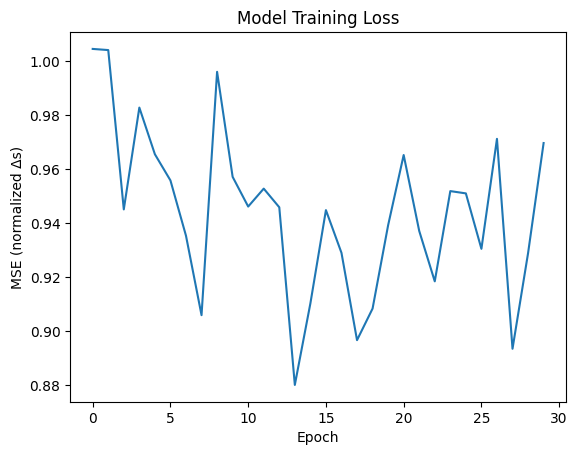

In [102]:
losses = train_model(model, replay)
plt.figure()
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("MSE (normalized Δs)")
plt.title("Model Training Loss")
plt.show()

In [103]:
def validate_model(env, model, steps=1000, rollout_horizon=20):
    model.eval()
    with th.no_grad():
        s, a, _, sp, _ = replay.sample(steps)
        ds_true = sp - s
        x = np.concatenate([s, a], axis=-1)
        x_n = inp_norm.normalize(x)
        pred_n = model(to_t(x_n)).cpu().numpy()
        ds_pred = targ_norm.denormalize(pred_n)
        one_step_mse = np.mean((ds_pred - ds_true) ** 2)

        multi_mse = []
        for _ in range(rollout_horizon):
            a = env.action_space.sample()
            x = np.concatenate([s, np.tile(a, (s.shape[0], 1))], axis=-1)
            x_n = inp_norm.normalize(x)
            ds_pred = targ_norm.denormalize(model(to_t(x_n)).cpu().numpy())
            s = s + ds_pred
            multi_mse.append(np.mean((s - sp) ** 2))  # rough growth measure

    print(f"One-step MSE: {one_step_mse:.6f}")
    for i, m in enumerate(multi_mse, 1):
        print(f"{i}-step open-loop MSE: {m:.6f}")


In [104]:
validate_model(env, model)

One-step MSE: 30.207352
1-step open-loop MSE: 30.743608
2-step open-loop MSE: 28.860884
3-step open-loop MSE: 27.268425
4-step open-loop MSE: 25.676490
5-step open-loop MSE: 24.634221
6-step open-loop MSE: 23.785067
7-step open-loop MSE: 22.932243
8-step open-loop MSE: 22.377578
9-step open-loop MSE: 21.895028
10-step open-loop MSE: 21.376569
11-step open-loop MSE: 20.955855
12-step open-loop MSE: 20.914521
13-step open-loop MSE: 20.812130
14-step open-loop MSE: 20.688678
15-step open-loop MSE: 20.613158
16-step open-loop MSE: 20.692194
17-step open-loop MSE: 21.003434
18-step open-loop MSE: 21.506163
19-step open-loop MSE: 21.697840
20-step open-loop MSE: 22.204983


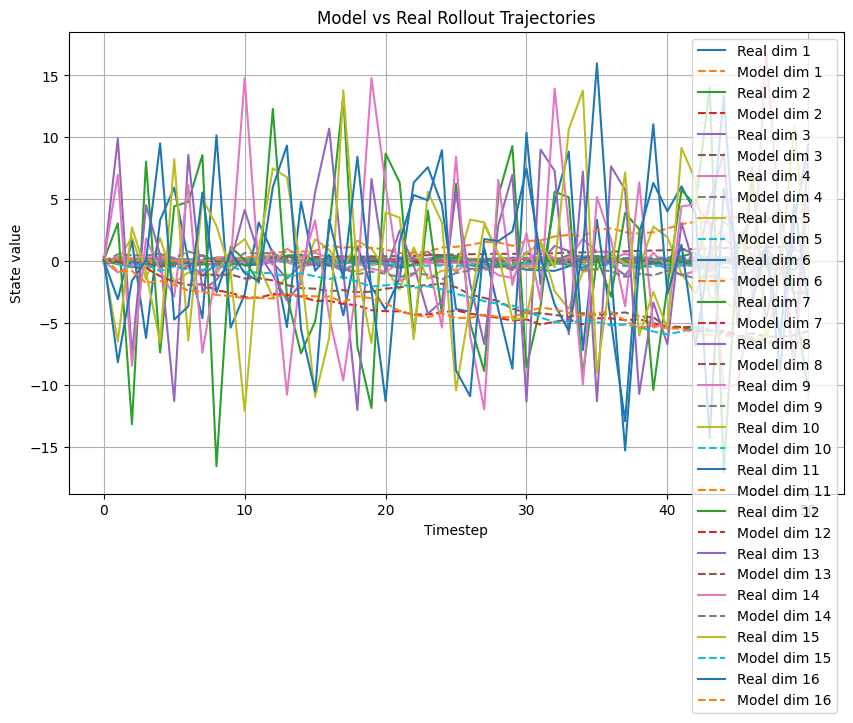

In [105]:
def visualize_rollout(env, model, k=50, dims=(0, 5, 10), seed=2025):
    model.eval()
    set_seed(seed)
    obs, _ = env.reset(seed=seed)

    # pre-sample k random actions so both env and model see the same inputs
    actions = [env.action_space.sample() for _ in range(k)]

    real_traj = [obs.copy()]
    model_traj = [obs.copy()]

    with th.no_grad():
        s_model = obs.copy()
        for a in actions:
            # step real env
            sp, r, term, trunc, _ = env.step(a)
            real_traj.append(sp.copy())
            if term or trunc:
                break

            # model prediction
            x = np.concatenate([s_model, a], axis=-1)
            x_n = inp_norm.normalize(x)
            ds_pred_n = model(to_t(x_n[None, :])).cpu().numpy()[0]
            ds_pred = targ_norm.denormalize(ds_pred_n)
            s_model = s_model + ds_pred
            model_traj.append(s_model.copy())

    real_traj = np.array(real_traj)
    model_traj = np.array(model_traj)

    plt.figure(figsize=(10, 6))
    for d in dims:
        plt.plot(real_traj[:, d], label=f"Real dim {d}")
        plt.plot(model_traj[:, d], '--', label=f"Model dim {d}")
    plt.title("Model vs Real Rollout Trajectories")
    plt.xlabel("Timestep")
    plt.ylabel("State value")
    plt.legend()
    plt.grid(True)
    plt.show()



dims = list(range(1, 17))
visualize_rollout(env, model, k=50, dims=dims) #(qvel_start, qvel_start+1, qvel_start+2))


The model seems to be overall okay. Its much better in the short term compared to letting it run for more steps (around 8-12 steps it deviates a lot).

The training is not enough for planning and definitley requires continual training.

We cannot learn this in one episode because it has many more dimenions than mountain car, its continuous, and unstable. All of these factors mean that while we can use one episode for mountain car we have to use multi episodic policies for Half Cheetah.

This is because state and action distributions change as we gather more and more data meaning it can't be static.
